In [1]:
# import libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms import ToTensor


In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
# download MNIST dataset
train_data = datasets.MNIST(
    root = "data",	
    train = True,
    download = True,
    transform = ToTensor()
)


test_data = datasets.MNIST(
    root = "data",
    train = False,
    transform = ToTensor()
)

In [4]:
print(train_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [5]:
print(test_data)

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [6]:
print(train_data.data.size())

torch.Size([60000, 28, 28])


In [7]:
print(train_data.targets.size())

torch.Size([60000])


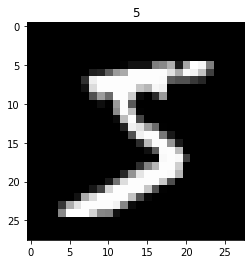

In [8]:
# plot one training example
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(train_data.data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.show()

In [9]:
# prepare data for training with DataLoader
from torch.utils.data import DataLoader
# The Dataset retrieves our dataset’s features and labels one sample at a time.

loaders = {
    'train': DataLoader(train_data, 
                        batch_size=64, 
                        shuffle=True,
                        num_workers=1),
    'test': DataLoader(test_data, 
                        batch_size=64, 
                        shuffle=True,
                        num_workers=1)
}


In [18]:
# define cnn model

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
            
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Linear(7*7*32, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.fc(x)
        return output, x    # return x for visualization

In [19]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)


In [20]:
# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)


In [21]:
# train the model
from torch.autograd import Variable

num_epochs = 5

def train(num_epochs):
    cnn.train()
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            images = Variable(images)
            labels = Variable(labels)
            
            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs, _ = cnn(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            if (i+1) % 100 == 0:
                print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f' 
                       %(epoch+1, num_epochs, i+1, len(train_data)//64, loss.data.item()))

train(num_epochs)


Epoch [1/5], Iter [100/937] Loss: 0.0566
Epoch [1/5], Iter [200/937] Loss: 0.0768
Epoch [1/5], Iter [300/937] Loss: 0.0483
Epoch [1/5], Iter [400/937] Loss: 0.0145
Epoch [1/5], Iter [500/937] Loss: 0.0489
Epoch [1/5], Iter [600/937] Loss: 0.0238
Epoch [1/5], Iter [700/937] Loss: 0.1135
Epoch [1/5], Iter [800/937] Loss: 0.0762
Epoch [1/5], Iter [900/937] Loss: 0.0824
Epoch [2/5], Iter [100/937] Loss: 0.0196
Epoch [2/5], Iter [200/937] Loss: 0.0190
Epoch [2/5], Iter [300/937] Loss: 0.0286
Epoch [2/5], Iter [400/937] Loss: 0.0208
Epoch [2/5], Iter [500/937] Loss: 0.1178
Epoch [2/5], Iter [600/937] Loss: 0.0041
Epoch [2/5], Iter [700/937] Loss: 0.0187
Epoch [2/5], Iter [800/937] Loss: 0.0619
Epoch [2/5], Iter [900/937] Loss: 0.1200
Epoch [3/5], Iter [100/937] Loss: 0.0167
Epoch [3/5], Iter [200/937] Loss: 0.0239
Epoch [3/5], Iter [300/937] Loss: 0.0734
Epoch [3/5], Iter [400/937] Loss: 0.0568
Epoch [3/5], Iter [500/937] Loss: 0.0018
Epoch [3/5], Iter [600/937] Loss: 0.0012
Epoch [3/5], Ite

In [22]:
# test the model
cnn.eval()
correct = 0
total = 0
for images, labels in loaders['test']:
    images = Variable(images)
    outputs, _ = cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the model on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the model on the 10000 test images: 98 %
